# House Price Prediction

This is a project in Kaggle (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview). The objective is to predict sales prices and practice feature engineering, RFs, and gradient boosting.

## 1 Understand Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler #Normalize the features (x) individually

import warnings
warnings.filterwarnings('ignore') # remove warnings


In [2]:
data_train = pd.read_csv('Data/train.csv')
data_test = pd.read_csv('Data/test.csv')

In [3]:
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 2 Analyze SalePrice

In [4]:
data_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

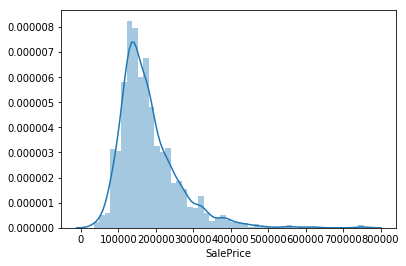

In [5]:
sns.distplot(data_train['SalePrice'])

In [6]:
print('Skewness: %f' %data_train['SalePrice'].skew())
print('Kurtosis: %f' %data_train['SalePrice'].kurtosis())

Skewness: 1.882876
Kurtosis: 6.536282


Kurtosis (Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution):
    - Kurtosis = 0, steepness is same with normal distribution
    - Kurtosis > 0, much steeper than the normal distribution
     
Skewness measures the relative size of the two tails. 
    - Skewness = 0, 
    - Skewness > 0, right tail
    - Skewness < 0, left tail
    
From the figure above,
    - Low range values are not too far away from 0.
    - High range values are far from 0, which means values are out of range.

In [7]:
# 2 Analyze Outliers
# 2.1 Analyze the SalePrice - Standardalize the data
SalePrice_scaled = StandardScaler().fit_transform(data_train['SalePrice'][:,np.newaxis])
low_range = SalePrice_scaled[SalePrice_scaled[:,0].argsort()][:10]
high_range= SalePrice_scaled[SalePrice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\n outer range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

 outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


## 3 Analyze independent variables

### 3.1 Which features are important?

Go through all the features, guess which ones might be closely correlated with the SalePrice.

### 3.2 Type of feature

#### 3.2.1 Relationship with numerical variables

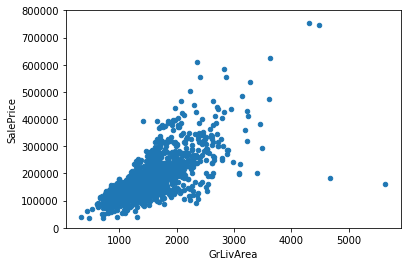

In [8]:
# scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
data.plot.scatter(x = var, y='SalePrice', ylim=(0,800000))

There is a linear relationship between saleprice & GrLivArea. But there are outliers. We can speculate why this is happening.
    - Outlier1 (GrLivArea>4000): Maybe they are agriculture area? It seems not reasonable, so we'll define them as outliers and delete them.
    - Outlier2 (SalePrice>700K): The SalePrice is high but they seem to be following the trend. So we will keep them.

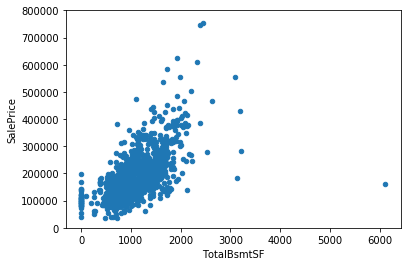

In [9]:
# scatter plot grlivarea/saleprice
var = 'TotalBsmtSF'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
data.plot.scatter(x = var, y='SalePrice', ylim=(0,800000))

There is also a linear relationship between TotalBsmtSF and SalePrice, though there are a few outliers when TotalBsmtSF=0. Also, the slope is higher than the GrLivArea plot.

The outlier "TotalBsmtSF">6000 seems to be not reasonable. This dot seems to be the same with the one in the above figure where "GrLivArea">5000. So we will delete this one.

#### 3.2.2 Relationship with categorical features

(-0.5, 9.5, 0, 800000)

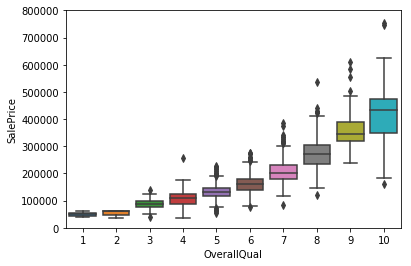

In [10]:
# 1. box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([data_train['SalePrice'],data_train[var]], axis=1)
fig = sns.boxplot(x = var, y = 'SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)

OverallQual is higher, SalePrice is higher, which is reasonable.

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

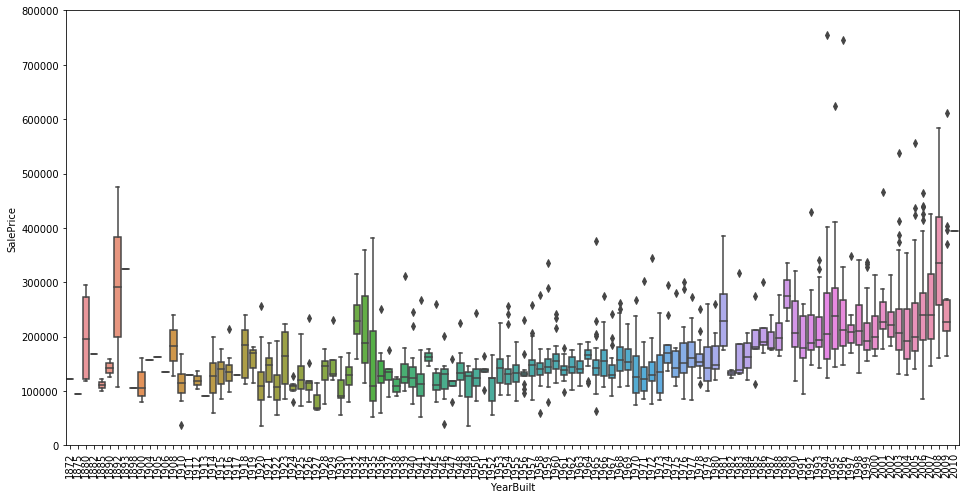

In [11]:
# 2. box plot YearBuilt/saleprice
# import matplotlib.ticker as ticker

var = 'YearBuilt'
data = pd.concat([data_train['SalePrice'],data_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16,8))

fig2 = sns.boxplot(x=var, y='SalePrice', data=data)
fig2.axis(ymin=0, ymax=800000)
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))   #set x scale as 10
plt.xticks(rotation=90)

Overall, SalePrice increases with YearBuilt, though there are a few outliers.

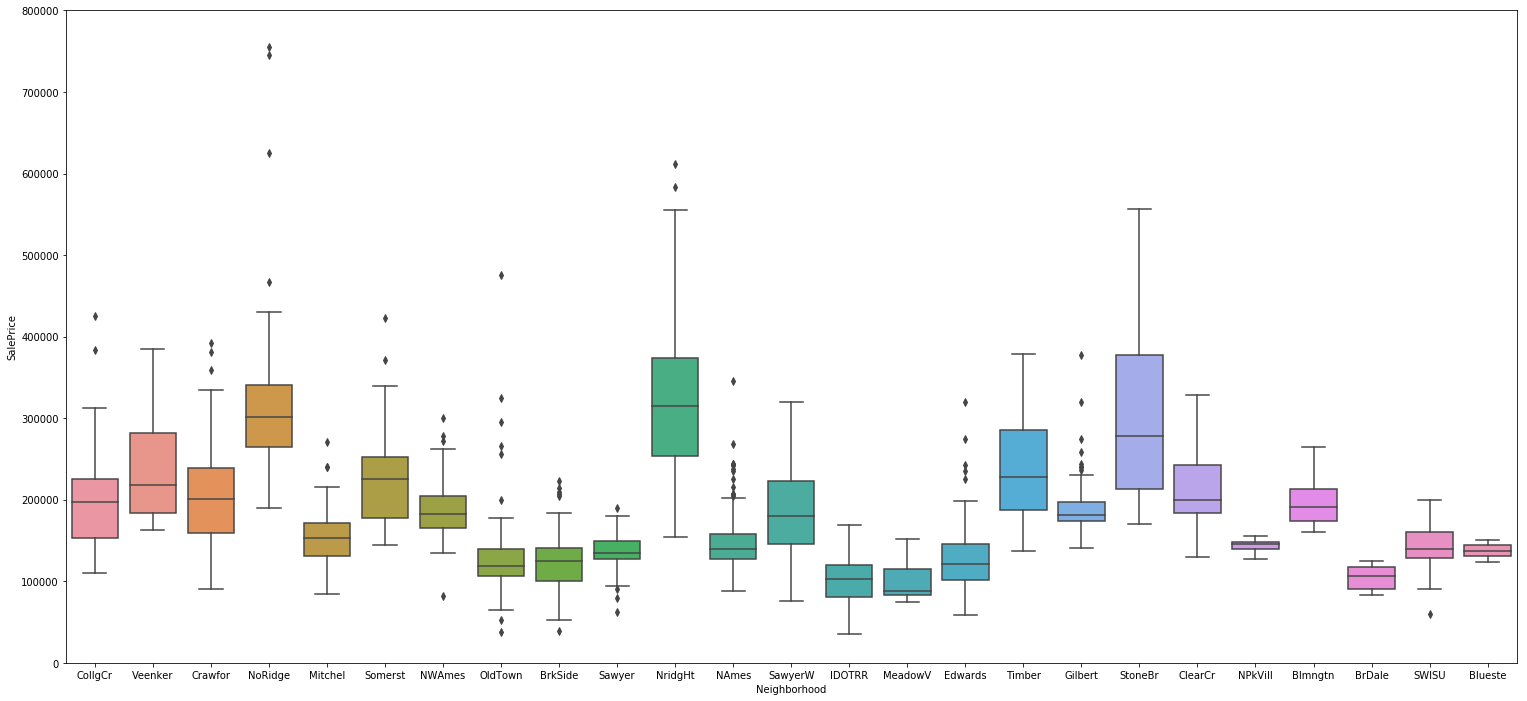

In [12]:
# 3. Neighborhood
var = 'Neighborhood'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
f, ax = plt.subplots(figsize=(26, 12))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
# Not easy to analyze due to the categorical data type. Let's leave it here for now. Later, we will use sklearn 
# to analyze this feature. 

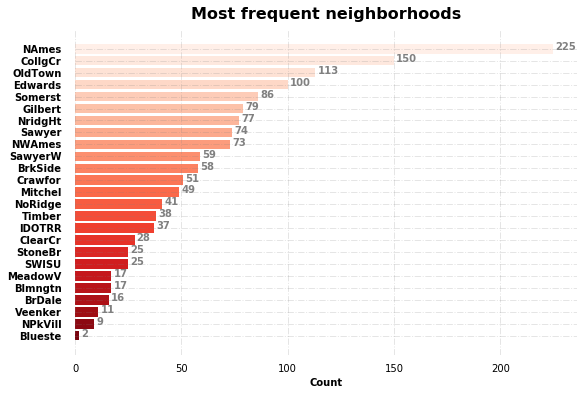

In [15]:
# 3. Neighborhood

# Figure Size
fig, ax = plt.subplots(figsize=(9,6))

# Horizontal Bar Plot
title_cnt=data_train['Neighborhood'].value_counts().sort_values(ascending=False).reset_index()
mn= ax.barh(title_cnt.iloc[:,0], title_cnt.iloc[:,1], color=sns.color_palette('Reds',len(title_cnt)))

# Remove axes splines
for s in ['top','bottom','left','right']:
    ax.spines[s].set_visible(False)

# Remove x,y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x,y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=1, alpha=0.2)

# Show top values 
ax.invert_yaxis()

# Add Plot Title
ax.set_title('Most frequent neighborhoods',weight='bold',
             loc='center', pad=10, fontsize=16)
ax.set_xlabel('Count', weight='bold')

# Add annotation to bars
for i in ax.patches:
    ax.text(i.get_width()+1, i.get_y()+0.5, str(round((i.get_width()), 2)),
            fontsize=10, fontweight='bold', color='grey')
plt.yticks(weight='bold')

# Show Plot
plt.show()

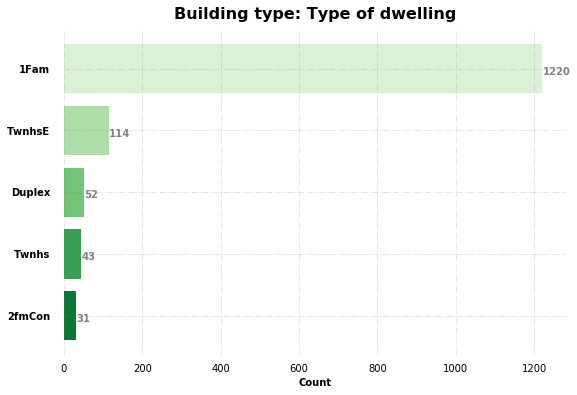

In [16]:
# BuildingType

fig, ax = plt.subplots(figsize=(9,6))

# Horizontal Bar Plot
title_cnt=data_train['BldgType'].value_counts().sort_values(ascending=False).reset_index()
mn= ax.barh(title_cnt.iloc[:,0], title_cnt.iloc[:,1], color=sns.color_palette('Greens',len(title_cnt)))

# Remove axes splines
for s in ['top','bottom','left','right']:
    ax.spines[s].set_visible(False)

# Remove x,y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x,y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=1, alpha=0.2)

# Show top values 
ax.invert_yaxis()

# Add Plot Title
ax.set_title('Building type: Type of dwelling',weight='bold',
             loc='center', pad=10, fontsize=16)
ax.set_xlabel('Count', weight='bold')


# Add annotation to bars
for i in ax.patches:
    ax.text(i.get_width()+1, i.get_y()+0.5, str(round((i.get_width()), 2)),
            fontsize=10, fontweight='bold', color='grey')
plt.yticks(weight='bold')


plt.show()


### 3.3 Relationship among different features 

#### 3.3.1 Create Correlation matrix (heatmap)

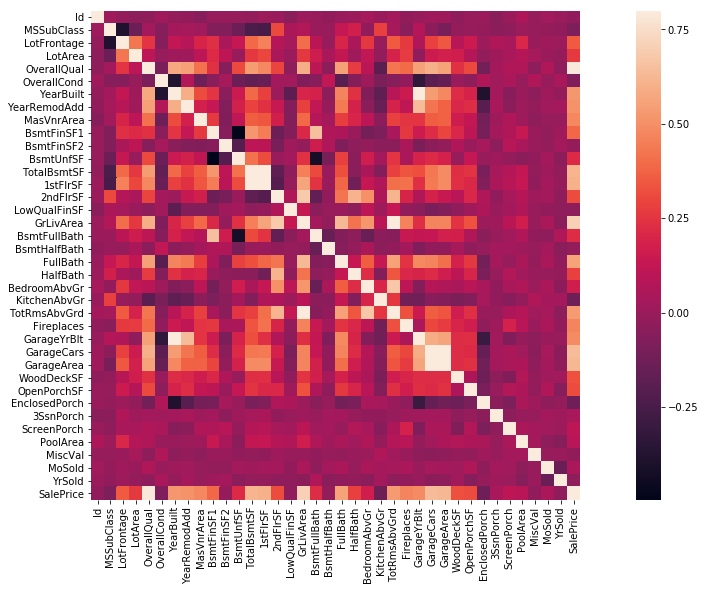

In [18]:
# correlation matrix
corrmat = data_train.corr()
f,ax=plt.subplots(figsize=(20,9))
sns.heatmap(corrmat, vmax=0.8, square=True)

# It seems this correlation map is only good at analyzing the numerical features. Therefore, the categorical data should 
# be analzed seperately.

The lighter the color (eg: 0.8), the more correlated the two parameters are. 

- First, There are two white squares, which gave almost the same information. 
    - TotalBsmtSF & 1stFlrSF        - 
    - GarageCares & GarageArea
- The parameters that are closely correlated with SalePrice are:
    - OverallQual
    - YearBuilt
    - ArLivArea
    - etc.

#### 3.3.2 Zoomed heatmap

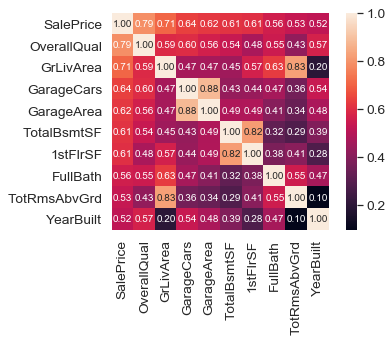

In [82]:
# saleprice correlation matrix
k=10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data_train[cols].values.T)
sns.set(font_scale=1.25)
hm=sns.heatmap(cm, cbar=True, annot=True,square=True,fmt='0.2f',
              annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Based on the above heatmap, the selected features are
    - OverallQual
    - GrLivArea
    - GarageCars (This provides the same info with GarageArea, so we only need to select one)
    - TotalBsmtSF (This is similar with 1stFlrSF, so we drop 1stFlrSF)
    - FullBath
    - TotRmsAbvGrd
    - YearBuilt

#### 3.3.3 Scatter plots between SalePrice & correlated variables

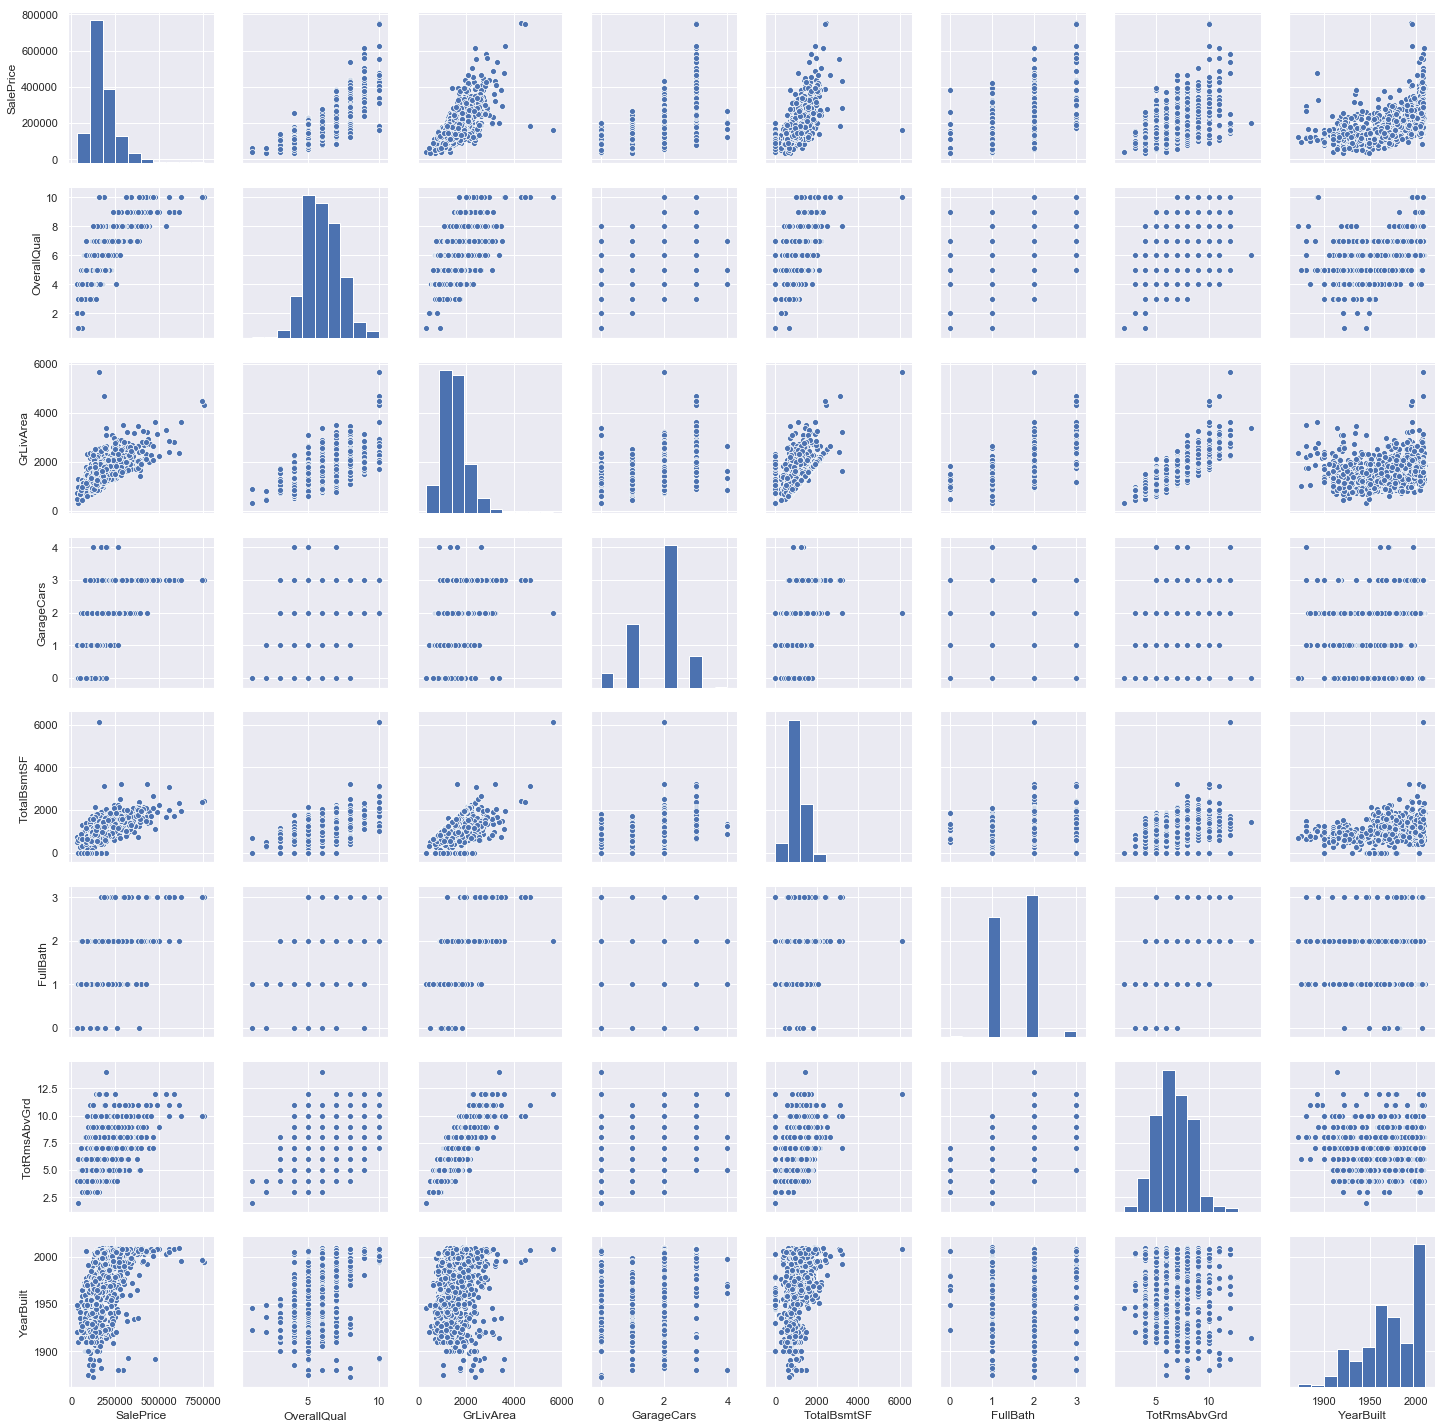

In [88]:
# scatterplot
sns.set()
cols=['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','TotRmsAbvGrd','YearBuilt']
sns.pairplot(data_train[cols], size=2.5)
plt.show()

## 4 Missing data & Outliars

In [136]:
# 1 calculate the % of missing data

total = data_train.isnull().sum().sort_values(ascending = False)
percent = (data_train.isnull().sum()/data_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent], axis=1,keys=['Total','Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


- For one column, if more than 15% of data is missing, then we should not consider this feature.
- Compare with the selcted features
    - The previously selected featurese are: cols=['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','TotRmsAbvGrd','YearBuilt']
    - we can relook at these features' missing percentage.

In [135]:
# only look at the selected features, to see if they have any missing data.
cols=['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','TotRmsAbvGrd','YearBuilt']
total_1 = data_train[cols].isnull().sum().sort_values(ascending = False)
percent_1 = (data_train[cols].isnull().sum()/data_train[cols].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_1,percent_1], axis=1,keys=['Total','Percent'])
missing_data

,Total,Percent
YearBuilt,0,0.0
TotRmsAbvGrd,0,0.0
FullBath,0,0.0
TotalBsmtSF,0,0.0
GarageCars,0,0.0
GrLivArea,0,0.0
OverallQual,0,0.0
SalePrice,0,0.0


In [141]:
# 2 Analyze Outliars
# 2.1 Analyze the SalePrice - Standardalize the data
SalePrice_scaled = StandardScaler().fit_transform(data_train['SalePrice'][:,np.newaxis])
low_range = SalePrice_scaled[SalePrice_scaled[:,0].argsort()][:10]
high_range= SalePrice_scaled[SalePrice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\n outer range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

 outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


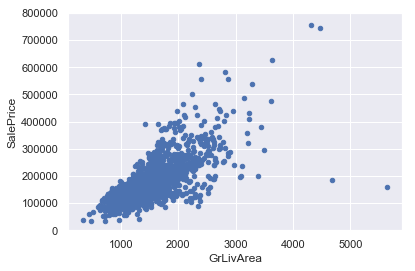

In [144]:
# 2 Analyze Outliars
# 2.2 Analyze the relationship of SalePrice & other variables

# 2.2.1 bivariate analysis saleprice/grlivarea
# Plot the relationship
var = 'GrLivArea'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

There is a linear relationship between saleprice & GrLivArea. But there are outliers. We can speculate why this is happening.
    - Outlier1 (GrLivArea>4000): Maybe they are agriculture area? It seems not reasonable, so we'll define them as outliers and delete them.
    - Outlier2 (SalePrice>700K): The SalePrice is high but they seem to be following the trend. So we will keep them.

In [152]:
# delete the outliers
GrLivArea_Out = data_train.sort_values(by='GrLivArea', ascending=False)[:2].index
data_train = data_train.drop(GrLivArea_Out)

# # double check and make sure the outliers have been deleted
# var = 'GrLivArea'
# data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
# data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [215]:
# Analyze the test data
X_test = data_test[cols]

# 1 see if there are missing data
total_test = X_test.isnull().sum().sort_values(ascending = False)
percent_test = (X_test.isnull().sum()/X_test.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total_test,percent_test], axis=1,keys=['Total','Percent'])
missing_data_test

,Total,Percent
TotalBsmtSF,1,0.000685
GarageCars,1,0.000685
YearBuilt,0,0.000000
TotRmsAbvGrd,0,0.000000
FullBath,0,0.000000
GrLivArea,0,0.000000
OverallQual,0,0.000000


In [216]:
# 2 Replace the missing data
# There is only one NULL in GarageCars/TotalBsmtSF columns. Calculate the mean value, and replacement the NULL with mean.
GarageCarsAvg = int(round(X_test['GarageCars'].mean())) # Garage cars # should be an int.
cars = X_test['GarageCars'].fillna(GarageCarsAvg)  
bsmt = X_test['TotalBsmtSF'].fillna(X_test['TotalBsmtSF'].mean())

cols2 = ['OverallQual','GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
X_test = pd.concat([X_test[cols2], cars, bsmt],axis=1)
X_test.isnull().sum()# make sure there is no NULL in the columns

OverallQual     0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
GarageCars      0
TotalBsmtSF     0
dtype: int64

## 4 Start modeling

In [91]:
from sklearn import preprocessing
from sklearn import linear_model, svm, gaussian_process
from sklearn.model_selection import train_test_split
import numpy as np

In [172]:
# Obtain target & predictors
cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'] # these are the selected features
X = data_train[cols]
y = data_train['SalePrice'].values
X_test = data_test[cols]

# Break validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,TotRmsAbvGrd,YearBuilt
618,9,1828,3,1822,2,9,2007
870,5,894,1,894,1,5,1962
92,5,964,2,876,1,5,1921
817,8,1689,3,1568,2,7,2002
302,7,1541,3,1541,2,6,2001


In [164]:
# Step1: Evaluate several models
from sklearn.ensemble import RandomForestRegressor

# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds) # use mean absolute error(MAE) as a criteria.

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("model_%d MAE: %d" % (i+1, mae))

model_1 MAE: 19166
model_2 MAE: 19161
model_3 MAE: 19086
model_4 MAE: 19662
model_5 MAE: 19326


In [173]:
# select the model with the lowest MAE score
my_model = model_3

In [219]:
# Fit the model to the training data
my_model.fit(X, y)

# Generate test predictions
preds_test = my_model.predict(X_test)

# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv(r'submission.csv', index=False)  # output to csv file

## 5 Other codes for reference

In [97]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor

# use the previously trained model
rfr = clf

data_test = pd.read_csv('Data/test.csv')
data_test[cols].isnull().sum()

OverallQual     0
GrLivArea       0
GarageCars      1
TotalBsmtSF     1
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
dtype: int64

In [99]:
# There is only one NULL in GarageCars/TotalBsmtSF columns. Calculate the mean value, and replacement the NULL with mean.


cols2 = ['OverallQual','GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
cars = data_test['GarageCars'].fillna(data_test['GarageCars'].mean())
bsmt = data_test['TotalBsmtSF'].fillna(data_test['TotalBsmtSF'].mean())
data_test_x = pd.concat( [data_test[cols2], cars, bsmt] ,axis=1)
data_test_x.isnull().sum() # make sure there is no NULL in the columns

OverallQual     0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
GarageCars      0
TotalBsmtSF     0
dtype: int64

In [100]:
x = data_test_x.values
y_te_pred = rfr.predict(x)
print(y_te_pred)

print(y_te_pred.shape)
print(x.shape)

[ 94114.51  105576.39  137376.78  ... 100108.385  94424.385 175531.375]
(1459,)
(1459, 7)


In [101]:
data_test_x.head()

,OverallQual,GrLivArea,FullBath,TotRmsAbvGrd,YearBuilt,GarageCars,TotalBsmtSF
0,5,896,1,5,1961,1.0,882.0
1,6,1329,1,6,1958,1.0,1329.0
2,5,1629,2,6,1997,2.0,928.0
3,6,1604,2,7,1998,2.0,926.0
4,8,1280,2,5,1992,2.0,1280.0


In [102]:
prediction = pd.DataFrame(y_te_pred, columns=['SalePrice'])
result = pd.concat([ data_test['Id'], prediction], axis=1)
# result = result.drop(result.columns[0], 1)
result.columns

Index(['Id', 'SalePrice'], dtype='object')

In [103]:
result.to_csv('./Predictions.csv', index=False)

Reference: https://www.kaggle.com/marsggbo/kaggle/notebook#%E5%9B%9B%E3%80%81%E5%BC%80%E5%A7%8B%E6%A8%A1%E6%8B%9F%E6%95%B0%E6%8D%AE
https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#Out-liars!